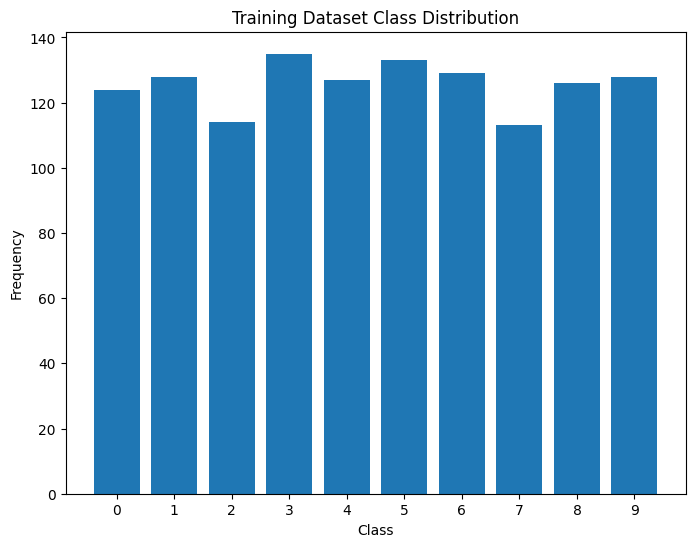

Class counts per class: [124 128 114 135 127 133 129 113 126 128]

Training on Digits Dataset:
Epoch 1/50, Train Loss: 2.0929, Validation Loss: 1.5909
Best model saved with validation loss: 1.5909
Epoch 2/50, Train Loss: 1.1085, Validation Loss: 0.6946
Best model saved with validation loss: 0.6946
Epoch 3/50, Train Loss: 0.5066, Validation Loss: 0.4984
Best model saved with validation loss: 0.4984
Epoch 4/50, Train Loss: 0.3133, Validation Loss: 0.3622
Best model saved with validation loss: 0.3622
Epoch 5/50, Train Loss: 0.2040, Validation Loss: 0.2542
Best model saved with validation loss: 0.2542
Epoch 6/50, Train Loss: 0.1457, Validation Loss: 0.2696
Epoch 7/50, Train Loss: 0.1107, Validation Loss: 0.2244
Best model saved with validation loss: 0.2244
Epoch 8/50, Train Loss: 0.0922, Validation Loss: 0.2441
Epoch 9/50, Train Loss: 0.0654, Validation Loss: 0.1859
Best model saved with validation loss: 0.1859
Epoch 10/50, Train Loss: 0.0650, Validation Loss: 0.1958
Epoch 11/50, Train Los

/tmp/ipykernel_27087/1449036800.py:206: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(model_name))


<Figure size 800x600 with 0 Axes>

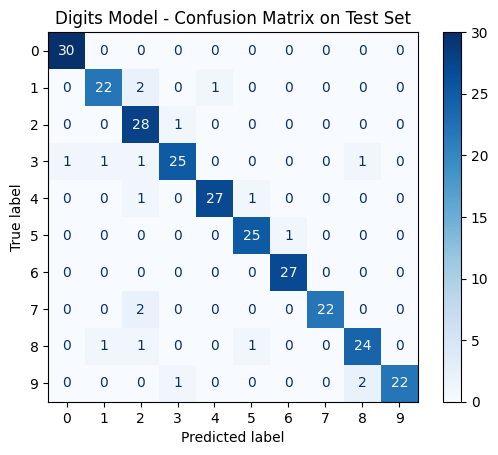

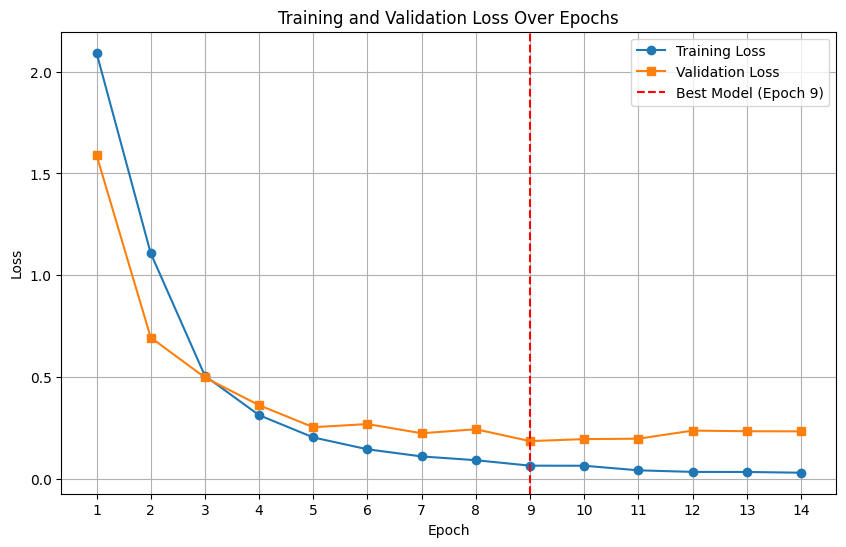

In [7]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, random_split, Dataset
import numpy as np
from sklearn import datasets
from sklearn.preprocessing import MinMaxScaler
from scipy.ndimage import zoom
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import torchvision.transforms as transforms

# Set random seed for reproducibility
def set_seed(seed=42):
    """Set random seed for reproducibility."""
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

set_seed(42)

# Load and prepare the Digits dataset from sklearn
digits = datasets.load_digits()
X_digits, y_digits = digits.data, digits.target

# Scale the features to [0, 1]
scaler = MinMaxScaler()
X_digits = scaler.fit_transform(X_digits)

# Reshape and resize the dataset to 28x28
X_digits = X_digits.reshape(-1, 8, 8)
zoom_factor = 28 / 8
X_digits_resized = np.array([zoom(img, zoom_factor) for img in X_digits])

# Convert to PyTorch tensors
X_digits_resized = torch.tensor(X_digits_resized).unsqueeze(1).float()
y_digits = torch.tensor(y_digits).long()

# Create custom Dataset with data augmentation
class DigitsDataset(Dataset):
    def __init__(self, images, labels, transform=None):
        self.images = images
        self.labels = labels
        self.transform = transform
        
    def __len__(self):
        return len(self.labels)
    
    def __getitem__(self, idx):
        image = self.images[idx]
        label = self.labels[idx]
        
        if self.transform:
            # Apply transformations
            image = self.transform(image)
        
        return image, label

# Define reduced data augmentation transforms
data_augmentation_transforms = transforms.Compose([
    transforms.ToPILImage(),
    transforms.RandomAffine(degrees=2, translate=(0.02, 0.02)),  # Reduced degrees and translation
    transforms.ToTensor(),
])

# Create datasets
dataset = DigitsDataset(X_digits_resized, y_digits, transform=None)  # No transform for the full dataset
train_size = int(0.7 * len(dataset))
valid_size = int(0.15 * len(dataset))
test_size = len(dataset) - train_size - valid_size
train_dataset, valid_dataset, test_dataset = random_split(
    dataset, [train_size, valid_size, test_size],
    generator=torch.Generator().manual_seed(42)
)

# Apply reduced data augmentation only to training data
train_dataset.dataset.transform = data_augmentation_transforms

# Create DataLoaders
batch_size = 64
train_loader_digits = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
valid_loader_digits = DataLoader(valid_dataset, batch_size=batch_size)
test_loader_digits = DataLoader(test_dataset, batch_size=batch_size)

# Get training labels distribution
train_labels = [y.item() for _, y in train_dataset]
class_counts = np.bincount(train_labels, minlength=len(np.unique(y_digits)))

# Plot the distribution of classes in the training dataset
plt.figure(figsize=(8, 6))
plt.bar(range(len(class_counts)), class_counts, tick_label=range(len(class_counts)))
plt.xlabel('Class')
plt.ylabel('Frequency')
plt.title('Training Dataset Class Distribution')
plt.show()

# Since the class distribution is relatively balanced, we can remove class weights
print("Class counts per class:", class_counts)

# =======================
# 3. Define the CNN Model with Dropout
# =======================

class DigitCNN(nn.Module):
    def __init__(self):
        super(DigitCNN, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, padding=1)  # Input channels: 1, Output channels: 32
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1) # Input channels: 32, Output channels: 64
        self.pool = nn.MaxPool2d(2, 2)  # Max pooling with a 2x2 window
        self.dropout = nn.Dropout(0.5)  # Dropout layer
        self.fc1 = nn.Linear(64 * 14 * 14, 128)  # Fully connected layer
        self.fc2 = nn.Linear(128, 10)  # Output layer for 10 classes

    def forward(self, x):
        x = torch.relu(self.conv1(x))  # Apply ReLU after first conv
        x = torch.relu(self.conv2(x))  # Apply ReLU after second conv
        x = self.pool(x)               # Apply max pooling
        x = self.dropout(x)            # Apply dropout
        x = x.view(-1, 64 * 14 * 14)   # Flatten the tensor
        x = torch.relu(self.fc1(x))    # Apply ReLU after first fully connected layer
        x = self.fc2(x)                # Output layer (logits)
        return x

# =======================
# 4. Define Training Function with Early Stopping
# =======================

def train_model(model, criterion, optimizer, train_loader, valid_loader, epochs=20, model_name="model.pth", patience=5, min_delta=0.0):
    """
    Train the CNN model with early stopping.

    Args:
        model: The CNN model to train.
        criterion: Loss function.
        optimizer: Optimization algorithm.
        train_loader: DataLoader for training data.
        valid_loader: DataLoader for validation data.
        epochs: Number of training epochs.
        model_name: Filename to save the trained model.
        patience: Number of epochs with no improvement after which training will be stopped.
        min_delta: Minimum change in the monitored quantity to qualify as an improvement.

    Returns:
        Tuple containing lists of training losses, validation losses per epoch, and the best epoch.
    """
    train_losses = []
    valid_losses = []
    best_valid_loss = np.inf
    best_epoch = 0
    epochs_no_improve = 0

    for epoch in range(epochs):
        model.train()
        running_train_loss = 0.0
        for inputs, labels in train_loader:
            # Move data to device
            inputs, labels = inputs.to(device), labels.to(device)

            optimizer.zero_grad()           # Zero the parameter gradients
            outputs = model(inputs)         # Forward pass
            loss = criterion(outputs, labels)  # Compute loss
            loss.backward()                 # Backward pass
            optimizer.step()                # Optimize

            running_train_loss += loss.item() * inputs.size(0)  # Accumulate loss

        epoch_train_loss = running_train_loss / len(train_loader.dataset)
        train_losses.append(epoch_train_loss)

        # Validation phase
        model.eval()
        running_valid_loss = 0.0
        with torch.no_grad():
            for inputs, labels in valid_loader:
                # Move data to device
                inputs, labels = inputs.to(device), labels.to(device)

                outputs = model(inputs)
                loss = criterion(outputs, labels)
                running_valid_loss += loss.item() * inputs.size(0)

        epoch_valid_loss = running_valid_loss / len(valid_loader.dataset)
        valid_losses.append(epoch_valid_loss)

        print(f"Epoch {epoch+1}/{epochs}, Train Loss: {epoch_train_loss:.4f}, Validation Loss: {epoch_valid_loss:.4f}")

        # Early stopping check
        if epoch_valid_loss + min_delta < best_valid_loss:
            best_valid_loss = epoch_valid_loss
            best_epoch = epoch + 1  # Save the best epoch (1-based indexing)
            epochs_no_improve = 0
            # Save the best model
            torch.save(model.state_dict(), model_name)
            print(f"Best model saved with validation loss: {best_valid_loss:.4f}")
        else:
            epochs_no_improve += 1
            if epochs_no_improve >= patience:
                print(f"Early stopping triggered after {epoch+1} epochs.")
                break

    # Load the best model
    model.load_state_dict(torch.load(model_name))
    print(f"Best model loaded from '{model_name}' with validation loss {best_valid_loss:.4f}")

    return train_losses, valid_losses, best_epoch

# =======================
# 5. Define Evaluation Function
# =======================

def evaluate_model(model, data_loader):
    """
    Evaluate the CNN model.

    Args:
        model: The trained CNN model.
        data_loader: DataLoader for test data.

    Returns:
        Tuple containing true labels and predicted labels.
    """
    model.eval()
    correct, total = 0, 0
    y_true = []
    y_pred = []
    running_loss = 0.0
    criterion = nn.CrossEntropyLoss()

    with torch.no_grad():
        for inputs, labels in data_loader:
            # Move data to device
            inputs, labels = inputs.to(device), labels.to(device)

            outputs = model(inputs)                    # Forward pass
            loss = criterion(outputs, labels)
            running_loss += loss.item() * inputs.size(0)
            _, predicted = torch.max(outputs, 1)       # Get the index of the max log-probability
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            y_true.extend(labels.cpu().numpy())
            y_pred.extend(predicted.cpu().numpy())

    accuracy = 100 * correct / total
    average_loss = running_loss / total
    print(f"Test Loss: {average_loss:.4f}, Test Accuracy: {accuracy:.2f}%")
    return y_true, y_pred, average_loss, accuracy

# =======================
# 6. Train the Model on Digits Dataset with Early Stopping and Reduced Data Augmentation
# =======================

# print("\nTraining on Digits Dataset:")
# model_digits = DigitCNN()
# # Move model to GPU if available
# device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# model_digits.to(device)

# # Remove class weights since the classes are balanced
# criterion = nn.CrossEntropyLoss()

# # Adjust learning rate
# optimizer = optim.Adam(model_digits.parameters(), lr=0.0005)

# train_losses, valid_losses, best_epoch = train_model(
#     model=model_digits,
#     criterion=criterion,
#     optimizer=optimizer,
#     train_loader=train_loader_digits,
#     valid_loader=valid_loader_digits,
#     epochs=50,  # Increase epochs if needed
#     model_name="digits_model.pth",
#     patience=3,  # Early stopping patience
#     min_delta=0.0005  # Minimum improvement to reset patience
# )


# =======================
# 7. Evaluate the Model on Test Set
# =======================

# =======================
# 6. Train the Model on Digits Dataset with Early Stopping and Reduced Data Augmentation
# =======================

print("\nTraining on Digits Dataset:")
model_digits = DigitCNN()
# Move model to GPU if available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model_digits.to(device)

# Loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model_digits.parameters(), lr=0.0005)

# Train the model and get the best model loaded automatically
train_losses, valid_losses, best_epoch = train_model(
    model=model_digits,
    criterion=criterion,
    optimizer=optimizer,
    train_loader=train_loader_digits,
    valid_loader=valid_loader_digits,
    epochs=50,  # Increase epochs if needed
    model_name="digits_model.pth",
    patience=5,  # Early stopping patience
    min_delta=0.0005  # Minimum improvement to reset patience
)

# =======================
# 7. Evaluate the Model on Test Set
# =======================

print("\nEvaluating the Best Model on Test Set:")
# Ensure model is in evaluation mode
model_digits.eval()
y_true_test, y_pred_test, test_loss, test_accuracy = evaluate_model(model_digits, test_loader_digits)

# Print evaluation results
print(f"Test Loss: {test_loss:.4f}")
print(f"Test Accuracy: {test_accuracy:.2f}%")

# =======================
# 8. Plot Confusion Matrix
# =======================

# Compute and plot the confusion matrix
cm_test = confusion_matrix(y_true_test, y_pred_test)
disp_test = ConfusionMatrixDisplay(confusion_matrix=cm_test, display_labels=range(10))

plt.figure(figsize=(8, 6))
disp_test.plot(cmap=plt.cm.Blues, values_format='d')
plt.title("Digits Model - Confusion Matrix on Test Set")
plt.show()

# =======================
# 9. Plot Training and Validation Loss with Best Epoch Highlighted
# =======================

plt.figure(figsize=(10, 6))
plt.plot(range(1, len(train_losses) + 1), train_losses, label='Training Loss', marker='o')
plt.plot(range(1, len(valid_losses) + 1), valid_losses, label='Validation Loss', marker='s')
plt.axvline(x=best_epoch, color='r', linestyle='--', label=f'Best Model (Epoch {best_epoch})')
plt.title("Training and Validation Loss Over Epochs")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.grid(True)
plt.xticks(range(1, len(train_losses) + 1))
plt.show()
